# MAST30034 Group23 Project 2: Buy Now, Pay Later project

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, regexp_replace, regexp_extract
from pyspark.sql.functions import sum, max
from pyspark.sql.functions import split
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import types as T

spark = SparkSession.builder\
    .appName("project_2")\
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

d:\anaconda\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
from pyspark.sql.functions import col, sum, max

In [3]:
import os
import sys
from pyspark.ml.feature import Word2Vec
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Tokenizer

import seaborn as sns
from pyspark.sql.functions import when, count, lower, trim, monotonically_increasing_id

In [4]:
folder_path1 = '../data/tables/transactions_20210228_20210827_snapshot'
df1 = spark.read.parquet(folder_path1)

folder_path2 = '../data/tables/transactions_20210828_20220227_snapshot'
df2 = spark.read.parquet(folder_path2)

folder_path3 = '../data/tables/transactions_20220228_20220828_snapshot'
df3 = spark.read.parquet(folder_path3)
transaction = df1.union(df2).union(df3).drop("order_id")

# Loading the dataset

c_match = spark.read.parquet("../data/tables/consumer_user_details.parquet")
c_raw_detail = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep = '|')
m_detail = spark.read.parquet('../data/tables/tbl_merchants.parquet')
m_fraud = spark.read.csv("../data/tables/merchant_fraud_probability.csv", header=True)
c_fraud = spark.read.csv("../data/tables/consumer_fraud_probability.csv", header=True)
c_detail = c_raw_detail.join(c_match, c_raw_detail["consumer_id"]==c_match["consumer_id"]).drop("consumer_id","name","address","gender")


In [5]:
#check for missing values
transaction_has_nulls = transaction.select([max(col(c).isNull().cast("int")).alias(c) for c in transaction.columns])
transaction_has_nulls.show()
m_detail_has_nulls = m_detail.select([max(col(c).isNull().cast("int")).alias(c) for c in m_detail.columns])
m_detail_has_nulls.show()
c_detail_has_nulls = c_detail.select([max(col(c).isNull().cast("int")).alias(c) for c in c_detail.columns])
c_detail_has_nulls.show()
m_fraud_has_nulls = m_fraud.select([max(col(c).isNull().cast("int")).alias(c) for c in m_fraud.columns])
m_fraud_has_nulls.show()
c_fraud_has_nulls = c_fraud.select([max(col(c).isNull().cast("int")).alias(c) for c in c_fraud.columns])
c_fraud_has_nulls.show()

+-------+------------+------------+--------------+
|user_id|merchant_abn|dollar_value|order_datetime|
+-------+------------+------------+--------------+
|      0|           0|           0|             0|
+-------+------------+------------+--------------+

+----+----+------------+
|name|tags|merchant_abn|
+----+----+------------+
|   0|   0|           0|
+----+----+------------+

+-----+--------+-------+
|state|postcode|user_id|
+-----+--------+-------+
|    0|       0|      0|
+-----+--------+-------+

+------------+--------------+-----------------+
|merchant_abn|order_datetime|fraud_probability|
+------------+--------------+-----------------+
|           0|             0|                0|
+------------+--------------+-----------------+

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|      0|             0|                0|
+-------+--------------+-----------------+



In [6]:
#check dimensions of datasets
transaction.count(), m_fraud.count(), m_detail.count(), c_fraud.count(), c_detail.count()

(14195505, 114, 4026, 34864, 499999)

In [7]:
#seperate information in m_detail
split_col = split(col("tags"), "\\|")
m_detail = m_detail.withColumn("tag", split_col.getItem(0))

m_detail = m_detail.withColumn("tags", regexp_replace(col("tags"), "\\[", "("))
m_detail = m_detail.withColumn("tags", regexp_replace(col("tags"), "\\]", ")"))

pattern = "\\(([a-e])\\)"
m_detail = m_detail.withColumn("revenue_level", regexp_extract(col("tags"), pattern, 1))

pattern_take_rate = "take rate: (\d+\.\d+)"

m_detail = m_detail.withColumn("take_rate", regexp_extract(col("tags"), pattern_take_rate, 1))

m_detail_final = m_detail

In [8]:
#check the relationship between revenue level and take rate of a merchant
from pyspark.sql import functions as F

m_detail = m_detail.withColumn("take_rate", m_detail["take_rate"].cast("float"))

stats_df = m_detail.groupBy("revenue_level").agg(
    F.min("take_rate").alias("min_take_rate"),
    F.max("take_rate").alias("max_take_rate")
)

pd_stats_df = stats_df.toPandas()
print(pd_stats_df)

  revenue_level  min_take_rate  max_take_rate
0             e           0.10           0.48
1             d           0.52           1.40
2             c           1.40           3.10
3             b           3.10           5.10
4             a           5.50           7.00


In [9]:
#combine m_detail with m_fraud
m_detail_fraud = m_detail.join(m_fraud, on='merchant_abn', how='left')

m_detail_fraud = m_detail_fraud.drop('tags')

In [10]:
#generate a statistical dataframe based on m_fraud
m_detail_fraud = m_detail_fraud.drop('order_datetime')

df_filtered = m_detail_fraud.filter(m_detail_fraud['fraud_probability'].isNotNull())

df_avg_fraud = df_filtered.groupBy('merchant_abn').agg({'fraud_probability': 'avg'})

df_avg_fraud = df_avg_fraud.withColumnRenamed('avg(fraud_probability)', 'avg_fraud_probability')

df_fraud_stats = df_filtered.groupBy('merchant_abn') \
    .agg({'fraud_probability': 'avg', '*': 'count'}) \
    .withColumnRenamed('avg(fraud_probability)', 'avg_fraud_probability') \
    .withColumnRenamed('count(1)', 'fraud_count')

In [11]:
#update m_detail with average fraud probability and fraud counts
m_detail_fraud1 = m_detail.join(df_fraud_stats, on='merchant_abn', how='left')

m_detail_fraud1 = m_detail_fraud1.drop('tags')

#attach c_detail to c_fraud
c_fraud_detail = c_fraud.join(c_detail, on='user_id', how='inner')

c_fraud_detail_tsn = c_fraud_detail.join(transaction, on=['user_id', 'order_datetime'], how='inner')

#find number of fraud consumers for each merchant
m_fraud_consumer_count = c_fraud_detail_tsn.groupBy('merchant_abn') \
    .agg(F.countDistinct('user_id').alias('fraud_consumer_count'))

#find average fraud probability of consumers for each merchant
m_avg_c_fraud = c_fraud_detail_tsn.groupBy('merchant_abn') \
    .agg({'fraud_probability': 'avg'}) \
    .withColumnRenamed('avg(fraud_probability)', 'avg_fraud_probability')

In [12]:
#find the fraud amount of consumers for each merchant
c_fraud_detail_tsn = c_fraud_detail_tsn.withColumn(
    'expected_fraud_amount', 
    c_fraud_detail_tsn['dollar_value'] * c_fraud_detail_tsn['fraud_probability'] / 100)

c_fraud_final = c_fraud_detail_tsn.drop('dollar_value', 'fraud_probability')

m_tot_c_fraud_amount = c_fraud_detail_tsn.groupBy('merchant_abn') \
    .agg({'expected_fraud_amount': 'sum'}) \
    .withColumnRenamed('sum(expected_fraud_amount)', 'total_fraud_amount')


Develop an ETL pipeline

In [56]:
def etl_pipeline(merchant_path, transaction_path1, transaction_path2, transaction_path3, consumer_path1, consumer_path2):
    # loading
    df1 = spark.read.parquet(transaction_path1)
    df2 = spark.read.parquet(transaction_path2)
    df3 = spark.read.parquet(transaction_path3)
    transaction = df1.union(df2).union(df3).drop("order_id")
    
    m_detail = spark.read.parquet(merchant_path)
    c_match = spark.read.parquet(consumer_path2)
    c_raw_detail = spark.read.csv(consumer_path1, header=True, sep = '|')
    c_detail = c_raw_detail.join(c_match, c_raw_detail["consumer_id"]==c_match["consumer_id"]).drop("consumer_id","name","address","gender")
    
    
    # Calculate total revenue for each merchant
    merchant_revenue = transaction.groupBy("merchant_abn").agg({"dollar_value": "sum"})

    # Rename the aggregated column to 'total_revenue'
    merchant_revenue = merchant_revenue.withColumnRenamed("sum(dollar_value)", "total_revenue")
    
    # Step 1: Calculate customer count by counting distinct 'user_id' from `transaction`
    customer_count_df = transaction.groupBy("merchant_abn").agg(F.countDistinct("user_id").alias("customer_count"))

    # Step 2: Calculate total revenue by summing 'dollar_value' for each 'merchant_abn'
    merchant_revenue = transaction.groupBy("merchant_abn").agg(F.sum("dollar_value").alias("total_revenue"))

    # Step 3: Join the customer_count and total_revenue back to the `merchants` DataFrame (m_detail)
    # Ensure `merchant_abn` column types match in `customer_count_df` and `merchant_revenue`
    m_detail = m_detail.withColumn("merchant_abn", m_detail["merchant_abn"].cast("long"))
    merchants = m_detail.join(customer_count_df, on="merchant_abn", how="left").join(merchant_revenue, on="merchant_abn", how="left")

    # Step 4: Fill any missing values for `customer_count` and `total_revenue`
    merchants = merchants.fillna({"customer_count": 0, "total_revenue": 0.0})

    # Step 5: Calculate new feature: revenue per customer
    merchants = merchants.withColumn("revenue_per_customer", merchants["total_revenue"] / merchants["customer_count"])

    # Handle division by zero (when customer_count is zero, set revenue_per_customer to 0)
    merchants = merchants.withColumn("revenue_per_customer", F.when(F.col("customer_count") == 0, 0).otherwise(F.col("revenue_per_customer")))
    
    merchants = merchants.fillna({'total_revenue': merchants.agg(F.mean('total_revenue')).first()[0]})
    transaction = transaction.dropna(subset=["dollar_value"])
    c_detail = c_detail.fillna('Unknown')


    merged_data = transaction.join(merchants, on='merchant_abn', how='left')
    merged_data = merged_data.join(c_detail,on='user_id' , how='left') 
    merged_data = merged_data.drop("consumer_id")
    merged_data = merged_data.drop("tag")
    
    

    
    # save data
    # merged_data.write.mode("overwrite").parquet('../data/curated/cleaned_merged_data.parquet')
    return merged_data

# Execute the ETL pipeline
cleaned_data = etl_pipeline('../data/tables/tbl_merchants.parquet', '../data/tables/transactions_20210228_20210827_snapshot','../data/tables/transactions_20210828_20220227_snapshot','../data/tables/transactions_20220228_20220828_snapshot' ,"../data/tables/tbl_consumer.csv","../data/tables/consumer_user_details.parquet")

Anomaly detection

In [57]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, countDistinct, avg
from sklearn.ensemble import IsolationForest

# Step 2: Feature Engineering for Merchant Anomaly Detection
# Calculate total revenue, number of unique customers, and average transaction value for each merchant
merchant_features = transaction.groupBy("merchant_abn").agg(
    F.sum("dollar_value").alias("total_revenue"),  
    F.countDistinct("user_id").alias("unique_customers"), 
    F.avg("dollar_value").alias("average_transaction_value") 
)

# Convert to Pandas DataFrame for use with Scikit-learn
merchant_features_pd = merchant_features.toPandas()

# Step 3: Handle missing or infinite values (if any)
merchant_features_pd = merchant_features_pd.fillna(0)
merchant_features_pd = merchant_features_pd.replace([float('inf'), -float('inf')], 0)

# Step 4: Anomaly Detection using Isolation Forest
# Initialize and fit the Isolation Forest model
merchant_model = IsolationForest(contamination=0.05, random_state=42)
merchant_features_pd['anomaly'] = merchant_model.fit_predict(
    merchant_features_pd[["total_revenue", "unique_customers", "average_transaction_value"]]
)

# Convert predictions back to Spark DataFrame
merchant_anomalies = spark.createDataFrame(merchant_features_pd)

# Step 5: Show the results
# Display the merchants classified as anomalies
merchant_anomalies.filter(merchant_anomalies['anomaly'] == -1).show()

# Optional: Save the results to a CSV or Parquet file for further analysis
# merchant_anomalies.write.parquet("merchant_anomalies.parquet", mode='overwrite')

d:\anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


+------------+------------------+----------------+-------------------------+-------+
|merchant_abn|     total_revenue|unique_customers|average_transaction_value|anomaly|
+------------+------------------+----------------+-------------------------+-------+
| 38700038932| 9546185.360697305|            6170|       1338.5004712138677|     -1|
| 99989036621| 56552.39444305644|               1|        56552.39444305644|     -1|
| 90568944804| 9618324.530454507|            8698|        896.2285250143968|     -1|
| 98518649381|3821722.4316547546|            3504|       1007.5724839585432|     -1|
| 43127814599| 5160928.759876952|            3564|       1332.1963758071636|     -1|
| 58729395250|2957138.7910835817|            2013|       1408.8322015643553|     -1|
| 29674997261|142066.08582788712|               6|        23677.68097131452|     -1|
| 46916077029|1040034.6932008725|              81|        12839.93448396139|     -1|
| 21319642626| 181291.0566193992|               8|         22661.

In [58]:
customer_features = transaction.groupBy("user_id").agg(
    F.sum("dollar_value").alias("total_spent"),           # Total spending by the customer
    F.count("dollar_value").alias("transaction_count"),   # Number of transactions
    F.avg("dollar_value").alias("average_transaction_value")  # Average value of each transaction
)

# Convert the customer features Spark DataFrame to a Pandas DataFrame for use with Scikit-learn
customer_features_pd = customer_features.toPandas()

# Handle any missing or infinite values (if present)
customer_features_pd = customer_features_pd.fillna(0)
customer_features_pd = customer_features_pd.replace([float('inf'), -float('inf')], 0)

# Display the first few rows to ensure proper conversion and handling
print(customer_features_pd.head())

# Initialize the Isolation Forest model
customer_model = IsolationForest(contamination=0.05, random_state=42)

# Train the Isolation Forest model on the customer features
# We use total_spent, transaction_count, and average_transaction_value as the features
customer_model.fit(customer_features_pd[["total_spent", "transaction_count", "average_transaction_value"]])

# Predict anomalies: -1 for outliers, 1 for inliers
customer_features_pd["anomaly"] = customer_model.predict(
    customer_features_pd[["total_spent", "transaction_count", "average_transaction_value"]]
)

# Display the number of anomalies detected
print("Number of anomalies detected:", (customer_features_pd["anomaly"] == -1).sum())

# Display a sample of the customers classified as anomalies
print(customer_features_pd[customer_features_pd["anomaly"] == -1].head())

# Convert the Pandas DataFrame back to a Spark DataFrame for further processing or saving
customer_anomalies = spark.createDataFrame(customer_features_pd)

# Show the anomalies in the Spark DataFrame
customer_anomalies.filter(customer_anomalies["anomaly"] == -1).show(10)

# Save the anomalies to a Parquet file for future analysis or reporting
# customer_anomalies.write.parquet("customer_anomalies.parquet", mode='overwrite')

   user_id    total_spent  transaction_count  average_transaction_value
0       26   94290.066114                588                 160.357255
1    18730   96322.244891                581                 165.786996
2      474  114137.088671                597                 191.184403
3    19141  109441.631247                597                 183.319315
4    19158   96380.828902                582                 165.602799


d:\anaconda\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


Number of anomalies detected: 1203
     user_id    total_spent  transaction_count  average_transaction_value  \
34      9233  130188.477242                614                 212.033351   
54     13518  130256.147651                577                 225.747223   
81     22429  131325.785761                585                 224.488523   
89     13460   87575.309156                615                 142.398877   
112       65  157215.941439                581                 270.595424   

     anomaly  
34        -1  
54        -1  
81        -1  
89        -1  
112       -1  
+-------+------------------+-----------------+-------------------------+-------+
|user_id|       total_spent|transaction_count|average_transaction_value|anomaly|
+-------+------------------+-----------------+-------------------------+-------+
|   9233| 130188.4772423228|              614|         212.033350557529|     -1|
|  13518| 130256.1476507151|              577|       225.74722296484418|     -1|
|  2242

In [60]:
# Outlier analysis (example: using IQR method to identify outliers)
# Convert the column to a Pandas Series
dollar_value_pd = cleaned_data.select('dollar_value').toPandas()

# Calculate the quantiles using Pandas
Q1 = dollar_value_pd['dollar_value'].quantile(0.25)
Q3 = dollar_value_pd['dollar_value'].quantile(0.75)
IQR = Q3 - Q1

# Filter out the outliers in the Spark DataFrame
outliers = cleaned_data.filter(
    (cleaned_data['dollar_value'] < (Q1 - 1.5 * IQR)) | 
    (cleaned_data['dollar_value'] > (Q3 + 1.5 * IQR))
)

print(f"Number of outliers: {outliers.count()}")

Number of outliers: 1534230


In [62]:
cleaned_data.show(3)

+-------+------------+-----------------+--------------+--------------------+--------------------+--------------+------------------+--------------------+-----+--------+
|user_id|merchant_abn|     dollar_value|order_datetime|                name|                tags|customer_count|     total_revenue|revenue_per_customer|state|postcode|
+-------+------------+-----------------+--------------+--------------------+--------------------+--------------+------------------+--------------------+-----+--------+
|     26| 83412691377|  51.124963532657|    2021-12-06|Suspendisse Sagit...|([watch, clock, a...|         10770| 498536.5816973136|  46.289376202164675|  VIC|    3469|
|     26| 83412691377|37.59252664573718|    2022-06-15|Suspendisse Sagit...|([watch, clock, a...|         10770| 498536.5816973136|  46.289376202164675|  VIC|    3469|
|     26| 10648956813|86.58263842410851|    2022-09-06|Proin Nisl Institute|[(computeRs, comp...|         14380|1419600.2971491965|   98.72046572664787|  VIC|  

In [63]:
# Handling missing values

# Calculate the mean value for `dollar_value` column
mean_dollar_value = cleaned_data.agg({"dollar_value": "mean"}).collect()[0][0]

# Fill missing `dollar_value` with the mean value
merged_data_filled = cleaned_data.fillna({"dollar_value": mean_dollar_value})


merged_data_filled = merged_data_filled.fillna({"name": "Unknown"})

merged_data_filled.show(5)

+-------+------------+-----------------+--------------+--------------------+--------------------+--------------+------------------+--------------------+-----+--------+
|user_id|merchant_abn|     dollar_value|order_datetime|                name|                tags|customer_count|     total_revenue|revenue_per_customer|state|postcode|
+-------+------------+-----------------+--------------+--------------------+--------------------+--------------+------------------+--------------------+-----+--------+
|     26| 83412691377|  51.124963532657|    2021-12-06|Suspendisse Sagit...|([watch, clock, a...|         10770| 498536.5816973136|  46.289376202164675|  VIC|    3469|
|     26| 83412691377|37.59252664573718|    2022-06-15|Suspendisse Sagit...|([watch, clock, a...|         10770| 498536.5816973136|  46.289376202164675|  VIC|    3469|
|     26| 10648956813|86.58263842410851|    2022-09-06|Proin Nisl Institute|[(computeRs, comp...|         14380|1419600.2971491965|   98.72046572664787|  VIC|  

In [64]:
print("Number of missing values in dollar_value column:", merged_data_filled.filter(merged_data_filled['dollar_value'].isNull()).count())

Number of missing values in dollar_value column: 0


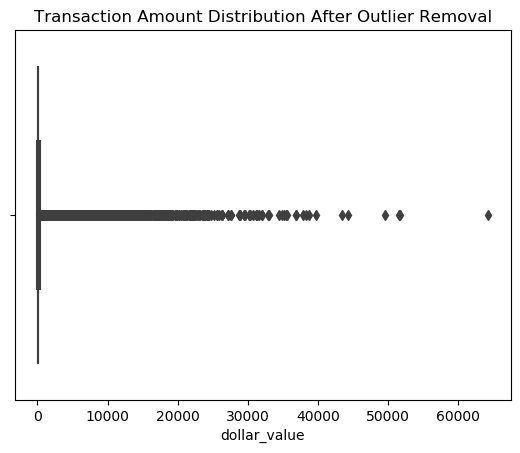

In [65]:
# Initialize Spark Session
spark = SparkSession.builder.appName("Data Distribution").getOrCreate()

# Assuming `merged_data_filled` is your initial DataFrame
# Step 1: Select the necessary column(s)
merged_data_filled_reduced = merged_data_filled.select('dollar_value')

# Step 2: Remove outliers using Spark transformations (assuming you have a filtering condition)
# Example: Remove rows where dollar_value is greater than a threshold (e.g., > 1000000)
outlier_removed_df = merged_data_filled_reduced.filter(col('dollar_value') <= 1000000)

# Step 3: Convert a sample to Pandas if required (using a very small sample)
sample_size = 1000000  # Adjust sample size as needed based on memory capacity
sample_df = outlier_removed_df.limit(sample_size).toPandas()

# Step 4: Plot using Seaborn or Matplotlib with the sampled data
sns.boxplot(x=sample_df['dollar_value'])
plt.title('Transaction Amount Distribution After Outlier Removal')
plt.show()

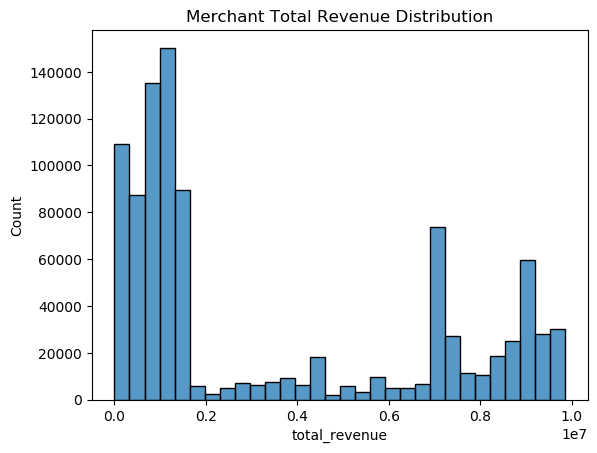

In [66]:
# Convert the necessary column to Pandas
sample_size = 1000000  # Adjust based on memory capacity
merged_data_sample = merged_data_filled.select("total_revenue").limit(sample_size).toPandas()

# Use seaborn to plot
sns.histplot(merged_data_sample['total_revenue'], bins=30)
plt.title('Merchant Total Revenue Distribution')
plt.show()

In [67]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Step 1: Set up a Spark session with increased memory limits to handle large datasets
spark = SparkSession.builder \
    .appName("CorrelationAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Step 2: Ensure columns contain numeric data only
numeric_columns = ['dollar_value', 'total_revenue', 'revenue_per_customer']  # Update with your numeric column names

# Step 3: Cast columns to double to ensure compatibility with correlation calculations
for column in numeric_columns:
    merged_data_filled = merged_data_filled.withColumn(column, col(column).cast("double"))

# Step 4: Remove or fill null and NaN values in the numeric columns
merged_data_filled = merged_data_filled.na.fill(0, subset=numeric_columns)

# Step 5: Create a feature vector for correlation
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
vector_df = assembler.transform(merged_data_filled).select("features")

# Step 6: Limit the dataset size if necessary to prevent memory overflow
vector_df_limited = vector_df.limit(1000)  # Adjust the limit based on your available memory

# Step 7: Compute the correlation matrix using the limited dataset
correlation_matrix = Correlation.corr(vector_df_limited, "features").head()[0]

# Step 8: Convert the correlation matrix to a numpy array for visualization or further processing
correlation_matrix_array = correlation_matrix.toArray()

# Step 9: Print the correlation matrix
print("Correlation Matrix:\n", correlation_matrix_array)

# Optional: If you want to use Pandas for visualization, you can convert the Spark DataFrame to a Pandas DataFrame (only for small datasets)
vector_df_limited_pd = vector_df_limited.limit(100).toPandas()  # Further reduce the limit if needed
correlation_matrix_pd = vector_df_limited_pd.corr()
print("Correlation Matrix (Pandas):\n", correlation_matrix_pd)

Correlation Matrix:
 [[ 1.         -0.04207247  0.53569056]
 [-0.04207247  1.          0.46023653]
 [ 0.53569056  0.46023653  1.        ]]
Correlation Matrix (Pandas):
 Empty DataFrame
Columns: []
Index: []


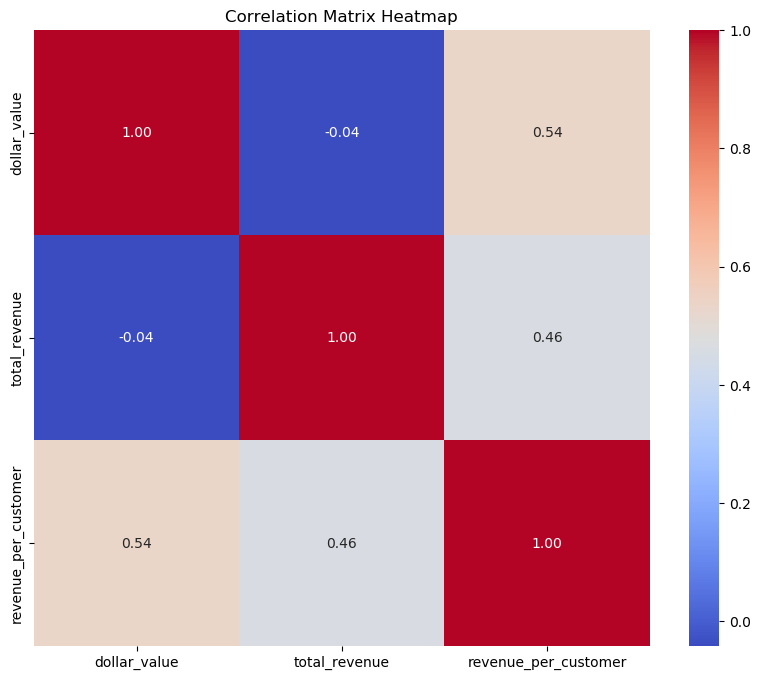

In [68]:
numeric_columns = ['dollar_value', 'total_revenue',  'revenue_per_customer']  # Update with your numeric column names

# Create a Pandas DataFrame using the numpy correlation matrix array
correlation_matrix_df = pd.DataFrame(data=correlation_matrix_array, columns=numeric_columns, index=numeric_columns)

# Step 2: Plot the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_df, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Use K-means to categorise the merchants

In [13]:
#extract tags without revenue level and take rate
m_detail = m_detail.withColumn("tag", regexp_replace(col("tag"), "\\[", "("))
m_detail = m_detail.withColumn("tag", regexp_replace(col("tag"), "\\]", ")"))
m_detail = m_detail.withColumn("extracted_tags", regexp_extract(col("tag"), r'\(\(([^)]+)\)', 1))
m_detail = m_detail.withColumn("tags_lower", lower(trim(col("extracted_tags"))))

In [14]:
#check random tags
m_detail_with_index = m_detail.withColumn("row_number", monotonically_increasing_id())
m_detail_filtered = m_detail_with_index.filter((m_detail_with_index["row_number"] >= 20) & (m_detail_with_index["row_number"] <= 51))

In [15]:
#K-means clustering the categories
tokenizer = Tokenizer(inputCol="tags_lower", outputCol="words")
m_detail_words = tokenizer.transform(m_detail)

word2vec = Word2Vec(vectorSize=300, minCount=1, inputCol="words", outputCol="features")
model = word2vec.fit(m_detail_words)
m_detail_vectors = model.transform(m_detail_words)

kmeans = KMeans(k=25, featuresCol="features", predictionCol="cluster", seed = 42)
kmeans_model = kmeans.fit(m_detail_vectors)

m_detail_clustered = kmeans_model.transform(m_detail_vectors)

In [16]:
m_detail_1 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 0).select('tags_lower', 'cluster').toPandas()
m_detail_2 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 1).select('tags_lower', 'cluster').toPandas()
m_detail_3 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 2).select('tags_lower', 'cluster').toPandas()
m_detail_4 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 3).select('tags_lower', 'cluster').toPandas()
m_detail_5 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 4).select('tags_lower', 'cluster').toPandas()
m_detail_6 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 5).select('tags_lower', 'cluster').toPandas()
m_detail_7 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 6).select('tags_lower', 'cluster').toPandas()
m_detail_8 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 7).select('tags_lower', 'cluster').toPandas()
m_detail_9 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 8).select('tags_lower', 'cluster').toPandas()
m_detail_10 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 9).select('tags_lower', 'cluster').toPandas()
m_detail_11 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 10).select('tags_lower', 'cluster').toPandas()
m_detail_12 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 11).select('tags_lower', 'cluster').toPandas()
m_detail_13 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 12).select('tags_lower', 'cluster').toPandas()
m_detail_14 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 13).select('tags_lower', 'cluster').toPandas()
m_detail_15 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 14).select('tags_lower', 'cluster').toPandas()
m_detail_16 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 15).select('tags_lower', 'cluster').toPandas()
m_detail_17 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 16).select('tags_lower', 'cluster').toPandas()
m_detail_18 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 17).select('tags_lower', 'cluster').toPandas()
m_detail_19 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 18).select('tags_lower', 'cluster').toPandas()
m_detail_20 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 19).select('tags_lower', 'cluster').toPandas()
m_detail_21 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 20).select('tags_lower', 'cluster').toPandas()
m_detail_22 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 21).select('tags_lower', 'cluster').toPandas()
m_detail_23 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 22).select('tags_lower', 'cluster').toPandas()
m_detail_24 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 23).select('tags_lower', 'cluster').toPandas()
m_detail_25 = m_detail_clustered.filter(m_detail_clustered["cluster"] == 24).select('tags_lower', 'cluster').toPandas()

In [17]:
m_detail_modified = m_detail_clustered.withColumn("cluster", 
                when(col("cluster") == 0, "Jewelry")
                .when(col("cluster") == 1, "Garden and Florist Retail")
                .when(col("cluster") == 2, "Bicycles")
                .when(col("cluster") == 3, "Digital Goods")
                .when(col("cluster") == 4, "Stationery and Office Supplies")
                .when(col("cluster") == 5, "Optical Goods")
                .when(col("cluster") == 6, "Books")
                .when(col("cluster") == 7, "Telecommunications")
                .when(col("cluster") == 8, "Telecommunications")
                .when(col("cluster") == 9, "Antique")
                .when(col("cluster") == 10, "Technology")
                .when(col("cluster") == 11, "Technology")
                .when(col("cluster") == 12, "Gift")
                .when(col("cluster") == 13, "Shoes")
                .when(col("cluster") == 14, "Furniture")
                .when(col("cluster") == 15, "Art and Craft Supplies")
                .when(col("cluster") == 16, "Garden and Florist Retail")
                .when(col("cluster") == 17, "Outdoor Equipment and Supplies")
                .when(col("cluster") == 18, "Furniture")
                .when(col("cluster") == 19, "Art and Craft Supplies")
                .when(col("cluster") == 20, "Jewelry Repair")
                .when(col("cluster") == 21, "Health and Beauty")
                .when(col("cluster") == 22, "Toy and Game Retail")
                .when(col("cluster") == 23, "Music")
                .when(col("cluster") == 24, "Automotive Sales")
                .otherwise(col("cluster")))

In [18]:
# Count the number of merchants in each category
m_detail_counts = m_detail_modified.groupBy("cluster").count().orderBy("count", ascending=False)

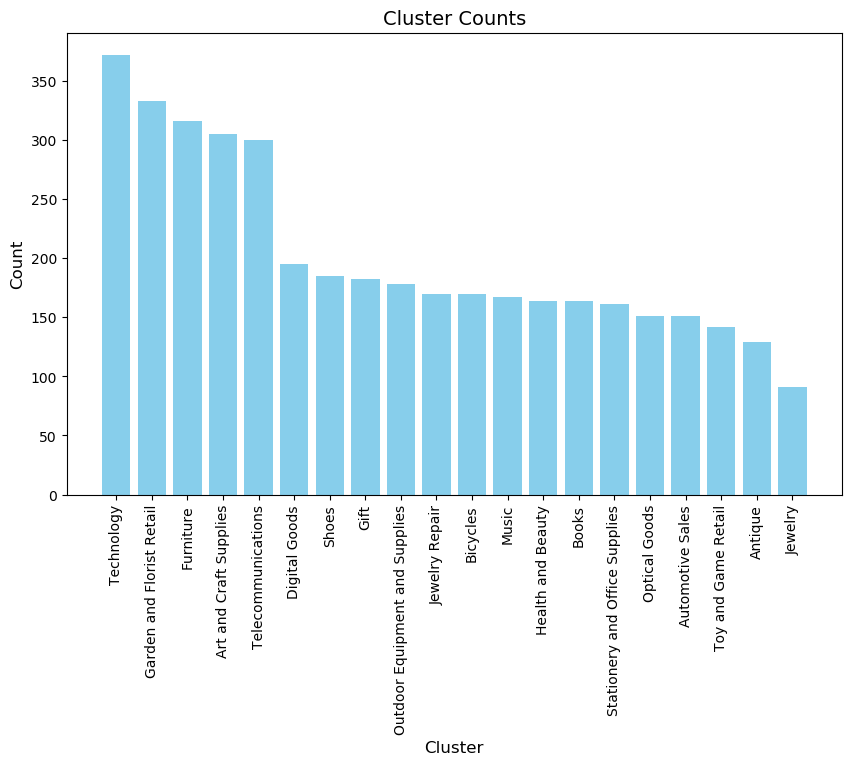

In [19]:
#visualize clueter counts

m_detail_pandas = m_detail_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(m_detail_pandas['cluster'], m_detail_pandas['count'], color='skyblue')

plt.title('Cluster Counts', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=90)
plt.show()

In [20]:
m_detail_modified = m_detail_modified.drop("tag", "extracted_tags", "tags_lower", "words", "features")

## Handling external datasets

In [24]:
#local path of external dataset
employee = pd.read_csv('../data/external/2021Census_W06B_AUST_POW_SA2.csv')
aus_postcode = pd.read_csv('../data/external/australian_postcodes.csv')
aus_population = pd.read_csv('../data/external/2021Census_G01_AUST_SA2.csv')
aus_income1 = pd.read_csv('../data/external/2021Census_G17B_AUST_SA2.csv')
aus_income2 = pd.read_csv('../data/external/2021Census_G17C_AUST_SA2.csv')

In [25]:
#find the average income level for each suberb
aus_income = pd.merge(aus_income1, aus_income2, on='SA2_CODE_2021', how='inner')
fixed = 'SA2_CODE_2021'
columns_to_keep = ['SA2_CODE_2021'] + [col for col in aus_income.columns if 'Tot' in col and col != fixed]
income = aus_income[columns_to_keep]
columns_to_keep1 = ['SA2_CODE_2021'] + [col for col in income.columns if 'F' not in col and col != fixed]
income1 = income[columns_to_keep1]
columns_to_keep2 = ['SA2_CODE_2021'] + [col for col in income1.columns if 'yrs' not in col and col != fixed]
income2 = income1[columns_to_keep2]
income3 = income2.drop(columns = ["P_Tot_85ov","P_Tot_Tot", "P_PI_NS_ns_Tot"])


medians = {
    'P_Neg_Nil_income_Tot': 0,
    'P_1_149_Tot': 75,
    'P_150_299_Tot': 225,
    'P_300_399_Tot': 350,
    'P_400_499_Tot': 450,
    'P_500_649_Tot': 575,
    'P_650_799_Tot': 725,
    'P_800_999_Tot': 900,
    'P_1000_1249_Tot': 1125,
    'P_1250_1499_Tot': 1375,
    'P_1500_1749_Tot': 1625,
    'P_1750_1999_Tot': 1875,
    'P_2000_2999_Tot': 2500,
    'P_3000_3499_Tot': 3250,
    'P_3500_more_Tot': 3500
}

weighted_sum = F.lit(0)
total_counts = F.lit(0)

for col in medians.keys():
    if col in income3.columns:
        weighted_sum += F.col(col) * medians[col]
        total_counts += F.col(col)
income3_py = spark.createDataFrame(income3)
income3_py = income3_py.withColumn('avg_income', F.when(total_counts != 0, weighted_sum / total_counts).otherwise(0))
income4 = income3_py.toPandas()
income_final = income4[['SA2_CODE_2021', 'avg_income']]

In [26]:
# Merge the employee dataset and the income dataset
employee = employee.rename(columns={'POW_SA2_CODE_2021': 'SA2_CODE_2021'}) # unified column name

# keep the columns we need
employee = employee[['SA2_CODE_2021', 'P_Tot_E']]
population = aus_population[['SA2_CODE_2021', 'Tot_P_P']]

#Join two dataframes on their SA2 code
aus_info = pd.merge(population, employee, on='SA2_CODE_2021', how='inner')
aus_info = pd.merge(aus_info, income_final, on='SA2_CODE_2021', how='inner')

In [27]:
# Keep sa2 code and postcode in the aus_postcode dataset
aus_postcode = aus_postcode[['postcode', 'SA2_CODE_2021']]

In [28]:
# Merge aus_postcode dataset and aus_info dataset on SA2_CODE_2021
aus_info_add_postcode = pd.merge(aus_info, aus_postcode, on='SA2_CODE_2021', how='left')

In [29]:
# Check the rows with null values in postcodes
aus_info_add_postcode['postcode'].isna().any()

True

In [30]:
# Delete the null-value rows
aus_info_cleaned = aus_info_add_postcode.dropna(subset=['postcode'])
aus_info_cleaned['postcode'].isna().any()

False

In [31]:
# Use postcode as index
aus_info_final = aus_info_cleaned.groupby('postcode').sum()
aus_info_final = aus_info_final.drop(columns=['SA2_CODE_2021'])
aus_info_final.head()

,Tot_P_P,P_Tot_E,avg_income
postcode,,,
800.0,14298,25058,2787.678883
810.0,29376,3472,19105.389222
812.0,27610,1518,13277.799285
820.0,34240,115140,22480.670103
822.0,1072038,467976,129985.665192


In [32]:
#define productivity of a suburb as its employment number multiply average income
aus_info_final['productivity'] = aus_info_final['avg_income']*aus_info_final['P_Tot_E']
aus_info_final.reset_index(inplace=True)
aus_info_final.rename(columns={'index': 'row_name'}, inplace=True)
aus_info_py = spark.createDataFrame(aus_info_final)

## Obtain all features for score ranking

In [33]:
#obtain a match dataframe from transaction with merchant_abn and consumer_id only
m_c_match = transaction.drop('dollar_value', 'order_datetime')
m_c_match = m_c_match.dropDuplicates()

In [34]:
#join suberb productivity to consumer detail
c_detail1 = c_detail.join(aus_info_py, on = 'postcode', how = 'left')
c_detail2 = c_detail1.drop('Tot_P_P','P_Tot_E','avg_income','state')
c_detail3 = c_detail2.drop('postcode')

In [35]:
#match consumer detail with productivity to transaction
tran_prod = transaction.join(c_detail3, on = 'user_id', how = 'left').drop('order_datetime', 'dollar_value')
tran_prod = tran_prod.dropna(subset = ['productivity'])

In [36]:
#find the average productivity of consumers for each merchant
average_productivity = tran_prod.groupBy("merchant_abn").agg(F.avg("productivity").alias("avg_productivity"))
m_detail_final = m_detail_final.join(average_productivity, on="merchant_abn", how='left')

#take a logarithm of base 10 so we it's more convenient to be used to rank
m_detail_final = m_detail_final.withColumn('log_prod', F.log("avg_productivity")/F.log(F.lit(10)))

m_detail_final_log = m_detail_final.drop("avg_productivity", 'tag', 'tags')

In [37]:
#find the total sales amount of each merchant
sales_per_merchant = transaction.groupBy('merchant_abn') \
    .agg(
        F.sum('dollar_value').alias('total_sales'),
        F.countDistinct('user_id').alias('customer_count')
    )

m_detail_final_revenue = m_detail_final_log.join(sales_per_merchant, on='merchant_abn', how='left')

In [38]:
#find the number of transactions of each merchant
transaction_count = transaction.groupBy("merchant_abn").count()

m_detail_final_counts = m_detail_final_revenue.join(transaction_count, on = "merchant_abn", how = 'inner')

m_detail_final_counts = m_detail_final_counts.withColumnRenamed("count", "transaction_count")

In [39]:
#find the number of frauds of each merchant with m_fraud
m_fraud_count = m_fraud.groupBy("merchant_abn").count()

m_detail_final_m_counts = m_detail_final_counts.join(m_fraud_count, on = 'merchant_abn', how = 'left')

m_detail_final_m_counts = m_detail_final_m_counts.na.fill({'count':0})

m_detail_final_m_counts = m_detail_final_m_counts.withColumnRenamed('count', 'm_fraud_count')

In [40]:
#find the earliest date that a merchant appears in transaction to avoid errors in new merchant
first_date_per_merchant = transaction.groupBy('merchant_abn') \
    .agg(F.min('order_datetime').alias('first_open_date'))

end_date = F.lit("2022-08-28").cast(T.DateType())

first_date_per_merchant = first_date_per_merchant.withColumn(
    'first_open_date', F.col('first_open_date').cast(T.DateType()))

days_open = first_date_per_merchant.withColumn(
    'days_open', F.datediff(end_date, F.col('first_open_date')))

m_detail_final_day = m_detail_final_m_counts.join(days_open, on='merchant_abn', how='left')

In [41]:
#add the number of total fraud amount from c_fraud to m_detail
m_detail_final_c_fraud_amount = m_detail_final_day.join(m_tot_c_fraud_amount, on = 'merchant_abn', how='left')

m_detail_final_c_fraud_amount = m_detail_final_c_fraud_amount.withColumnRenamed('total_fraud_amount','c_fraud_amount')

In [42]:
#define the total fraud amount of merchants using m_fraud and transaction
aggregated_transactions = transaction.groupBy('merchant_abn', 'order_datetime') \
    .agg(
        F.sum('dollar_value').alias('total_dollar_value')
    )

fraud_transactions = aggregated_transactions.join(m_fraud, on=['merchant_abn', 'order_datetime'], how='inner')

fraud_transactions = fraud_transactions.withColumn(
    'fraud_value', F.col('total_dollar_value') * F.col('fraud_probability') / 100 
)

aggregated_fraud = fraud_transactions.groupBy('merchant_abn') \
    .agg(
        F.sum('fraud_value').alias('total_fraud_value')
    )

m_detail_final_m_fraud_amount = m_detail_final_c_fraud_amount.join(aggregated_fraud, on = 'merchant_abn', how = 'left')


m_detail_final_m_fraud_amount = m_detail_final_m_fraud_amount.withColumnRenamed('total_fraud_value', 'm_fraud_amount')

In [43]:
#find the total number of consumers appear in c_fraud for each merchant
c_fraud_count = c_fraud.groupBy('user_id').count()

joined_df = c_fraud_count.join(m_c_match, on='user_id', how='inner')

result_df = joined_df.groupBy('merchant_abn').agg(F.sum('count').alias('total_consumer_count'))

m_c_fraud_count = c_fraud_count.join(m_c_match, on = 'user_id', how = 'inner')
mc_fraud_count = m_c_fraud_count.groupBy('merchant_abn').agg(F.sum('count').alias('total_consumer_count'))

m_detail_ult_raw = m_detail_final_m_fraud_amount.join(mc_fraud_count, on = 'merchant_abn', how = 'left')

In [44]:
#c_fraud_count is the number of consumers who have fraud history for a merchant
m_detail_ult_raw = m_detail_ult_raw.withColumnRenamed('total_consumer_count', 'c_fraud_count')

#fill all NULL value as 0
m_detail_ult_raw = m_detail_ult_raw.na.fill({'c_fraud_amount':0, 'm_fraud_amount':0, 'c_fraud_count':0})

In [45]:
#define the fraud index for each merchant
m_detail_ult_1 = m_detail_ult_raw.withColumn('m_fraud_index', when(m_detail_ult_raw['m_fraud_count']!=0,
                                            F.pow((m_detail_ult_raw['m_fraud_amount']/m_detail_ult_raw['total_sales']), (1/m_detail_ult_raw['m_fraud_count']))).otherwise(0))

m_detail_ult_2 = m_detail_ult_1.withColumn('c_fraud_index',
                                            F.pow((m_detail_ult_1['c_fraud_amount']/m_detail_ult_1['total_sales']), (m_detail_ult_1['c_fraud_count']/m_detail_ult_1['transaction_count'])))

In [46]:
#determine the daily revenue of bnpl company for each merchant
m_detail_daily = m_detail_ult_2.withColumn('daily_revenue', m_detail_ult_2['total_sales']/m_detail_ult_2['days_open'])

m_detail_all = m_detail_daily.withColumn('bnpl_daily_revenue', m_detail_daily['daily_revenue']*m_detail_daily['take_rate'])

In [47]:
#find the max and min of each feature used in the final model
max_min = m_detail_all.agg(F.max('log_prod').alias('max_log_prod'), F.min('log_prod').alias('min_log_prod'),
                            F.max('customer_count').alias('max_customer_count'), F.min('customer_count').alias('min_customer_count'),
                            F.max('m_fraud_index').alias('max_m_fraud_index'), F.min('m_fraud_index').alias('min_m_fraud_index'),
                            F.max('bnpl_daily_revenue').alias('max_bnpl_daily_revenue'), F.min('bnpl_daily_revenue').alias('min_bnpl_daily_revenue'),
                            F.max('c_fraud_index').alias('max_c_fraud_index'), F.min('c_fraud_index').alias('min_c_fraud_index'))

In [48]:
#define the model for score calculation
max_score_df = max_min.withColumn('max_score', max_min['max_log_prod'] + F.log(max_min['max_customer_count'])
                                         + F.log(max_min['max_bnpl_daily_revenue']) * 2 + 10
                                         + 5 + 40)
max_score = max_score_df.collect()[0]['max_score']

m_detail_score = m_detail_all.withColumn('score', (m_detail_all['log_prod'] + F.log(m_detail_all['customer_count'])
                                         + F.log(m_detail_all['bnpl_daily_revenue']) * 2 + 10 * (1 - m_detail_all['m_fraud_index'])
                                         + (5 - m_detail_all['c_fraud_index']) + 40)/max_score * 100)

In [71]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Check for 'score' column existence and ensure it has no null values
m_detail_score = m_detail_score.fillna({'score': 0})

# Step 2: Add a dummy partition column
m_detail_score = m_detail_score.withColumn("dummy_partition", F.lit(1))

# Step 3: Define the window specification based on the dummy partition and score column
windowSpec = Window.partitionBy("dummy_partition").orderBy(F.desc("score"))

# Step 4: Apply the ranking function over the defined window
m_detail_ranked = m_detail_score.withColumn("rank", F.rank().over(windowSpec))

# Step 5: Drop the dummy partition column
m_detail_ranked = m_detail_ranked.drop("dummy_partition")

# Step 6: Show the final ranked DataFrame
m_detail_ranked.show(10)


+------------+--------------------+-------------+---------+-----------------+-----------------+--------------+-----------------+-------------+---------------+---------+------------------+------------------+-------------+--------------------+--------------------+------------------+------------------+-----------------+----+
|merchant_abn|                name|revenue_level|take_rate|         log_prod|      total_sales|customer_count|transaction_count|m_fraud_count|first_open_date|days_open|    c_fraud_amount|    m_fraud_amount|c_fraud_count|       m_fraud_index|       c_fraud_index|     daily_revenue|bnpl_daily_revenue|            score|rank|
+------------+--------------------+-------------+---------+-----------------+-----------------+--------------+-----------------+-------------+---------------+---------+------------------+------------------+-------------+--------------------+--------------------+------------------+------------------+-----------------+----+
| 32361057556|Orci In Conseq

In [72]:
m_detail_ranked.select("merchant_abn", "score", "rank").show(10)

+------------+-----------------+----+
|merchant_abn|            score|rank|
+------------+-----------------+----+
| 32361057556|97.91111942811122|   1|
| 21439773999| 97.7075425655173|   2|
| 64403598239| 97.6708818912486|   3|
| 86578477987|97.57613582524422|   4|
| 45629217853|97.56104356732124|   5|
| 96680767841|97.51196941993095|   6|
| 94493496784|97.51181750681957|   7|
| 49322182190|97.41909678586241|   8|
| 89726005175|97.39556270746742|   9|
| 72472909171|97.26805364634339|  10|
+------------+-----------------+----+
only showing top 10 rows



In [73]:
m_detail_with_cluster = m_detail_modified.select('merchant_abn', 'cluster')

In [74]:
m_detail_ranked_category = m_detail_ranked.join(m_detail_with_cluster, on = 'merchant_abn', how = 'left')
m_detail_ranked_category.select('name', 'score', 'rank', 'cluster').show(truncate = False)

+------------------------------+-----------------+----+------------------------------+
|name                          |score            |rank|cluster                       |
+------------------------------+-----------------+----+------------------------------+
|Orci In Consequat Corporation |97.91111942811122|1   |Gift                          |
|Mauris Non Institute          |97.7075425655173 |2   |Telecommunications            |
|Lobortis Ultrices Company     |97.6708818912486 |3   |Music                         |
|Leo In Consulting             |97.57613582524422|4   |Jewelry Repair                |
|Lacus Consulting              |97.56104356732124|5   |Gift                          |
|Ornare Limited                |97.51196941993095|6   |Automotive Sales              |
|Dictum Phasellus In Institute |97.51181750681957|7   |Gift                          |
|Gravida Mauris Incorporated   |97.41909678586241|8   |Jewelry Repair                |
|Est Nunc Consulting           |97.39556270

In [75]:
technology_m_detail = m_detail_ranked_category.filter(m_detail_ranked_category['cluster']=='Technology')
technology_m_detail.select('name', 'score', 'rank', 'cluster').show(5, truncate = False)

+--------------------------+-----------------+----+----------+
|name                      |score            |rank|cluster   |
+--------------------------+-----------------+----+----------+
|Arcu Sed Eu Incorporated  |97.11058522481542|12  |Technology|
|Eu Placerat LLC           |96.73703799102279|19  |Technology|
|Diam At Foundation        |96.68140544747284|20  |Technology|
|Eleifend PC               |96.53230090235776|24  |Technology|
|Adipiscing Elit Foundation|96.42060410665896|28  |Technology|
+--------------------------+-----------------+----+----------+
only showing top 5 rows



In [76]:
gfr_m_detail = m_detail_ranked_category.filter(m_detail_ranked_category['cluster']=='Garden and Florist Retail')
gfr_m_detail.select('name', 'score', 'rank', 'cluster').show(5, truncate = False)

+------------------------------+-----------------+----+-------------------------+
|name                          |score            |rank|cluster                  |
+------------------------------+-----------------+----+-------------------------+
|Lorem Ipsum Sodales Industries|96.85218660140049|16  |Garden and Florist Retail|
|Auctor Company                |96.6497632488988 |22  |Garden and Florist Retail|
|Purus Gravida Sagittis Ltd    |96.49086217828457|25  |Garden and Florist Retail|
|Eu Inc.                       |96.41845587680086|29  |Garden and Florist Retail|
|Semper Corp.                  |96.18558484174244|39  |Garden and Florist Retail|
+------------------------------+-----------------+----+-------------------------+
only showing top 5 rows



In [77]:
furniture_m_detail = m_detail_ranked_category.filter(m_detail_ranked_category['cluster']=='Furniture')
furniture_m_detail.select('name', 'score', 'rank', 'cluster').show(5, truncate = False)

+------------------------------+-----------------+----+---------+
|name                          |score            |rank|cluster  |
+------------------------------+-----------------+----+---------+
|Phasellus At Limited          |97.07386642776318|13  |Furniture|
|Interdum Feugiat Sed Inc.     |96.28460456041739|35  |Furniture|
|Phasellus Dapibus Incorporated|95.79000587555493|47  |Furniture|
|Amet Risus Inc.               |95.77089449073434|49  |Furniture|
|Eget Laoreet Posuere PC       |94.80743756312145|76  |Furniture|
+------------------------------+-----------------+----+---------+
only showing top 5 rows



In [78]:
acs_m_detail = m_detail_ranked_category.filter(m_detail_ranked_category['cluster']=='Art and Craft Supplies')
acs_m_detail.select('name', 'score', 'rank', 'cluster').show(5, truncate = False)

+---------------------------------+-----------------+----+----------------------+
|name                             |score            |rank|cluster               |
+---------------------------------+-----------------+----+----------------------+
|Odio Phasellus Institute         |96.82015019496866|18  |Art and Craft Supplies|
|Elit Sed Consequat Associates    |96.48352280137196|26  |Art and Craft Supplies|
|Magna Malesuada Corp.            |96.38263371430561|31  |Art and Craft Supplies|
|Vehicula Pellentesque Corporation|96.18696610720247|38  |Art and Craft Supplies|
|Magna Sed Industries             |95.40368320079345|62  |Art and Craft Supplies|
+---------------------------------+-----------------+----+----------------------+
only showing top 5 rows



In [79]:
telecommunications_m_detail = m_detail_ranked_category.filter(m_detail_ranked_category['cluster']=='Telecommunications')
telecommunications_m_detail.select('name', 'score', 'rank', 'cluster').show(5, truncate = False)

+---------------------------------+-----------------+----+------------------+
|name                             |score            |rank|cluster           |
+---------------------------------+-----------------+----+------------------+
|Mauris Non Institute             |97.7075425655173 |2   |Telecommunications|
|Nec Incorporated                 |95.50819649519386|56  |Telecommunications|
|Posuere Cubilia Curae Corporation|95.47144370517454|59  |Telecommunications|
|Eu Dolor Egestas PC              |93.51764450444982|121 |Telecommunications|
|At Sem Corp.                     |93.47733943551378|125 |Telecommunications|
+---------------------------------+-----------------+----+------------------+
only showing top 5 rows

